# First try for Titanic survival predicion

## 1. Introduction


This is the first time working on the titanic dataset for me, and first time doing an machine learning project from scratch. Somethings I do very troughly to get the hang of it. The notebook is still work in progress, and will evolve and be improved until I sumbit the answer with a goal of being top 10.


This script follows three main parts:

* Feature analysis
* Feature engineering
* Modeling



In [69]:
#data handling
import pandas as pd
import numpy as np
import re

#plotting
from matplotlib import pyplot as plt
import seaborn as sns


#configuring plots
sns.set_style("whitegrid")


#statistics
from scipy.stats import pearsonr
from sklearn import preprocessing


#modelling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier

#results
from sklearn.metrics import roc_curve, auc


#others
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as PImage


## 2. Loading data  and check data

### 2.1 Loading data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### 2.2 Join test and train data

In order to perform the same feature engineering and get the same number of categories, I join the test and train data. I'll do the distribution checks and impute value fill-functions based on the training data though.

In [3]:
df_dataset = pd.concat(objs = [df_train, df_test]).reset_index(drop = True)
train_len = len(df_train)

#store it away to compare prediction accuracy on totally untouched data
del df_test
del df_train
#make df_train a reference to df_dataset
df_train = df_dataset[:train_len]

In [4]:
df_train.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


### 2.2 Check for null and missing values

In [5]:
df_dataset = df_dataset.fillna(np.nan)
df_dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Age and cabin columns has significant amounts of missing values.I'll look into how ta handle those at the next stage. As survived columns does not exist in test data, there is not really 418 missing values as can be seen if I only look at the training data.

I'll just fill the missing fare value with the madian. It will not change the distribution with only one value

In [6]:
df_dataset['Fare'] = df_dataset['Fare'].fillna(df_train['Fare'].median())

## 3 Feature analysis

### 3.1 Overview of categorical values

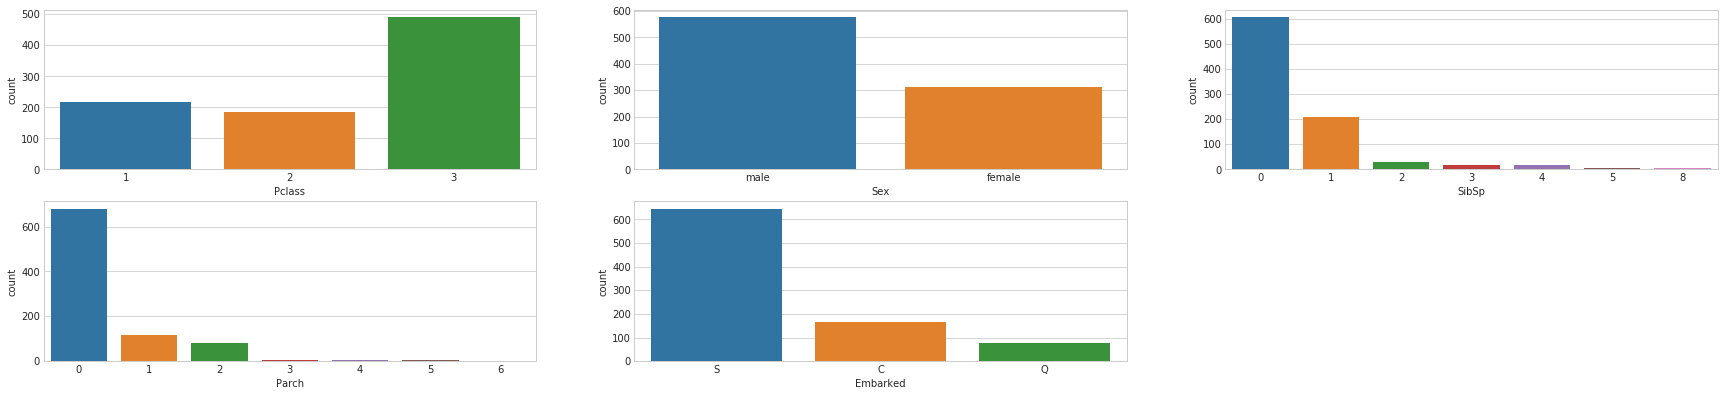

In [7]:
cols =  [ 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

#Distribution
fig = plt.figure(figsize=(30, 10))
for i in range (0,len(cols)):
    fig.add_subplot(3,3,i+1)
    sns.countplot(x=cols[i], data=df_train);  

plt.show()
fig.clear()

Only SibSp and Parch seems sparse. We'll look at the correlations and how it looks when you look at survival rate

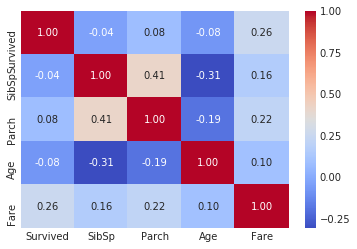

In [8]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
sns.heatmap(df_train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Age and number of siblings/spouses is negatively correlated, meaning younger persons have more siblings which seems obvious. Sibsp (number of siblings/spouses) and parch (number of parents/children) is also highly correlation, as both shows how large families were. Only Fare shows a correlation to survival, but there can other meaningfull correlations to survival in the subpopulations of the features. I'll explore them one by one.

I'll aggregate the sparse cartegories sibsp in the feature engineering part

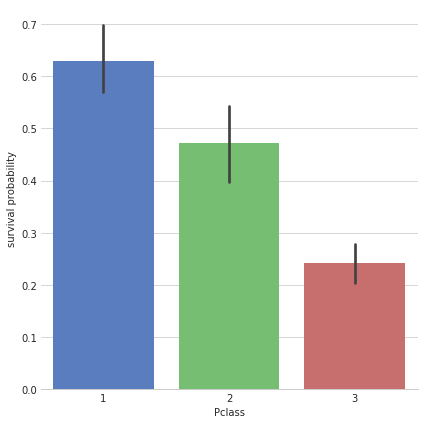

In [9]:
# Explore Pclass vs survived
g = sns.factorplot(x="Pclass",y="Survived",data=df_train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

The higher your class, the higher your survival rate. Makes sense if you've seen the movie.

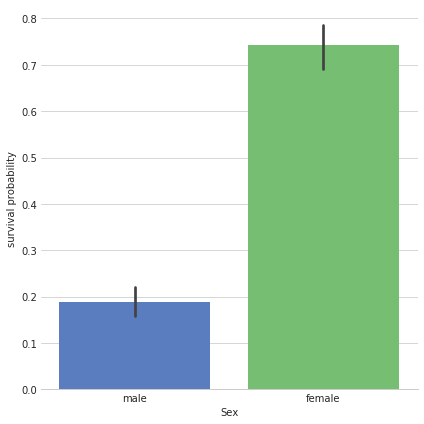

In [10]:
# Explore Sex feature vs Survived
g = sns.factorplot(x="Sex",y="Survived",data=df_train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

"Women and children first"

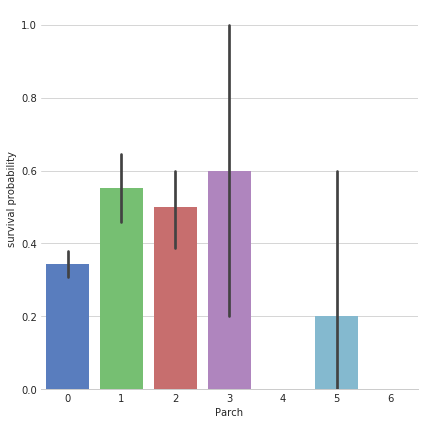

In [11]:
# Explore parch feature vs Survived
g = sns.factorplot(x="Parch",y="Survived",data=df_train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Traveling with a large family was not good for your survival probability. Makes sense that big families did not want to leave anyone behind :( To be two seems to be best (then you could maybe help eachother but have no trouble keeping together).

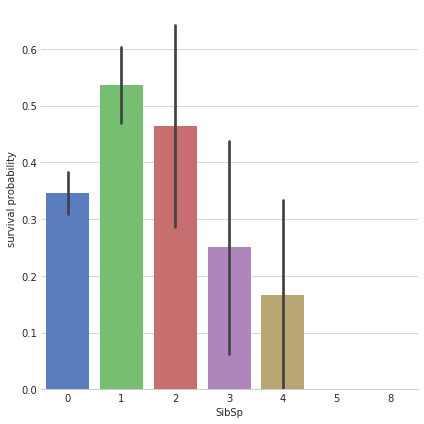

In [12]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=df_train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

This is a bit more clear than the parch feature. Seems like, the more siblings you have, your survival probability declines.  To be two or three seems to be best here as well. (then you could maybe help eachother but have no trouble keeping together)

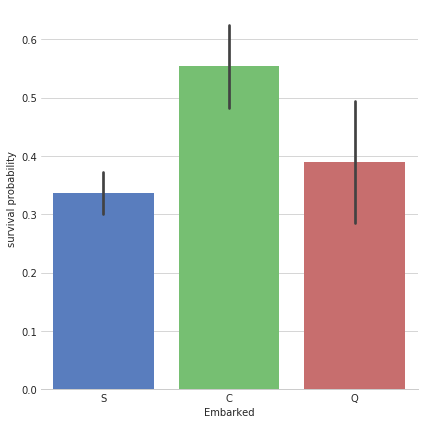

In [13]:
# Explore embarked feature vs Survived
g = sns.factorplot(x="Embarked",y="Survived",data=df_train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton. C is in France.

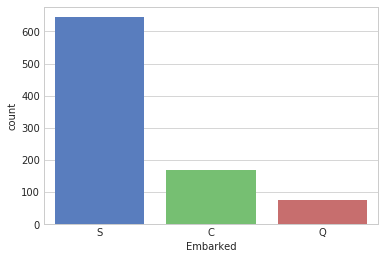

In [14]:
# Explore embarked feature 
g = sns.countplot(x="Embarked",data=df_train, palette = "muted")

I'll use this as it is, only creating a dummy variable of it

In [15]:
df_dataset = pd.get_dummies(df_dataset,columns = ['Embarked'])

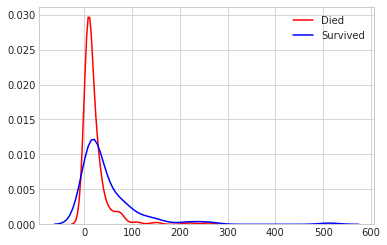

In [16]:
sns.kdeplot(df_train.loc[df_train['Survived'] == 0]['Fare'].dropna() , color="red", label="Died")
sns.kdeplot(df_train.loc[df_train['Survived'] == 1]['Fare'].dropna() , color="blue", label="Survived")
#sns.plt.legend()

Fare seems to say a bit about your survival probability, but how does the distribution look? 

skewness = 4.787316519674893


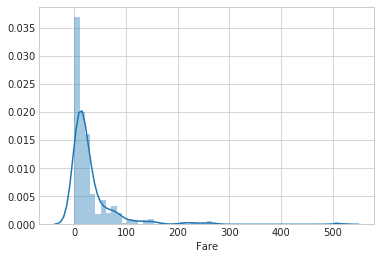

In [17]:
sns.distplot(df_train['Fare'])
print('skewness = {}'.format(df_train['Fare'].skew()))

The fare distribution is skewed, I'll log it to make it easier to handle

In [18]:
df_dataset['Fare'] = df_dataset['Fare'].apply(lambda row: np.log(row) if row > 0 else 0)

skewness = 4.787316519674893


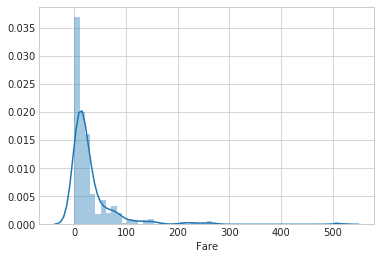

In [19]:
sns.distplot(df_train['Fare'])
print('skewness = {}'.format(df_train['Fare'].skew()))

Age distribution

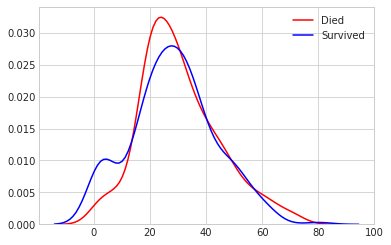

In [20]:
sns.kdeplot(df_train.loc[df_train['Survived'] == 0]['Age'].dropna() , color="red", label="Died")
sns.kdeplot(df_train.loc[df_train['Survived'] == 1]['Age'].dropna() , color="blue", label="Survived")

Age seems to matter for survival. I'll fix the missing age values by seeing if I can use some other features to get a better fillvalue than mean of the whole distribution.

Age and siblings/spouses had the highest correlation - I'll look if we have higher correlations in the subpopulations

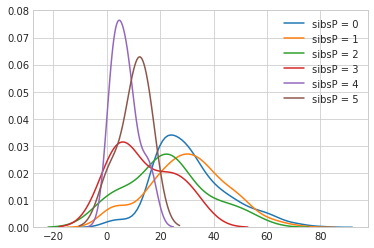

In [21]:
#colors = ['green', 'blue']
for i,sibsp in enumerate(np.unique(df_dataset['SibSp'])):
    if len(df_train.loc[df_train['SibSp'] == sibsp]) > 1:
        try:
            sns.kdeplot(df_train.loc[df_train['SibSp'] == sibsp]['Age'].dropna() , label="sibsP = {}".format(sibsp))
        except ValueError:
            pass

In [22]:
for i in np.unique(df_train['SibSp']):
    corr_data = df_train[['SibSp', 'Age', 'Survived']].dropna(how = 'any')
    age = corr_data.loc[corr_data['SibSp'] == i]['Age']
    survived = corr_data.loc[corr_data['SibSp'] == i]['Survived']
    print("Correlation and p-value of sibSP = {}:  {}".format(i,pearsonr(age, survived)))

Correlation and p-value of sibSP = 0:  (-0.12208746285996529, 0.007989905801481366)
Correlation and p-value of sibSP = 1:  (-0.11341120580592919, 0.12635820100167436)
Correlation and p-value of sibSP = 2:  (-0.26512182800295375, 0.20026054559648704)
Correlation and p-value of sibSP = 3:  (0.8864195589397436, 0.00012266819229976334)
Correlation and p-value of sibSP = 4:  (0.12047830774396714, 0.6339380831997368)
Correlation and p-value of sibSP = 5:  (nan, 1.0)
Correlation and p-value of sibSP = 8:  (nan, nan)


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


The correlations and p-values looks good for some of the groups - I'll keep this as it is

Text(0.5,1,'Sex and survival')

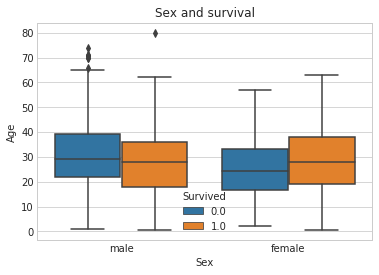

In [23]:
sns.boxplot(x ='Sex', y ='Age', hue ='Survived', data= df_train).set_title('Sex and survival')

Older men were more likely to die whereas younger older women were more likely to survive. This is even more obvious if we look at the age distribution of the survivors and them who died divided by sex. Men also has more outliers in the distribution. 


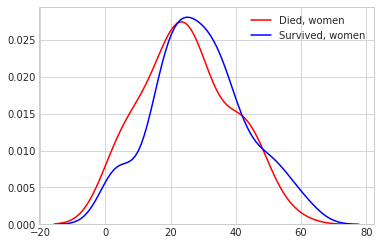

In [24]:
sns.kdeplot(df_train.loc[(df_train['Survived'] == 0) & (df_train['Sex'] == 'female') ]['Age'].dropna() , color="red", label="Died, women")
sns.kdeplot(df_train.loc[(df_train['Survived'] == 1) & (df_train['Sex'] == 'female') ]['Age'].dropna() , color="blue", label="Survived, women")

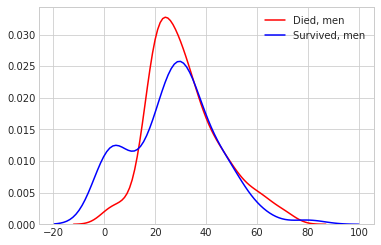

In [25]:
sns.kdeplot(df_train.loc[(df_train['Survived'] == 0) & (df_train['Sex'] == 'male') ]['Age'].dropna() , color="red", label="Died, men")
sns.kdeplot(df_train.loc[(df_train['Survived'] == 1) & (df_train['Sex'] == 'male') ]['Age'].dropna() , color="blue", label="Survived, men")

In [26]:
df_dataset = pd.get_dummies(df_dataset,columns = ['Sex'])

# 4 Feature engineering

There is a lot of features to be created if you're a bit creative

## 4.1 Extracting features from name

Names back in the day always included an honorific, which means I can extract loads of information.

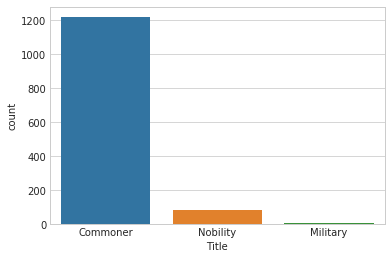

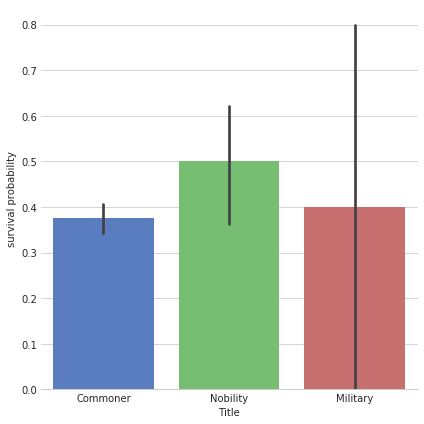

In [27]:
def mapTitle(title):
    dTitle = {'Mr': 'Commoner',
              'Mrs': 'Commoner',
              'Miss':'Commoner',
              'Ms':'Commoner',
              'Sir': 'Nobility',
              'Mme':'Commoner',
              'Lady': 'Nobility',
              'Mlle':'Commoner',
              'Col': 'Military',
              'Capt':'Military',
              'Don': 'Nobility',
              'Dona': 'Nobility',
              'the Countess': 'Nobility',
              'Jonkheer': 'Nobility',
              'Major':'Military',
              'Master':'Nobility',
              'Rev': 'Nobility',
              'Dr': 'Nobility'
             }
    
    try:
        return dTitle[title]
    except KeyError:
        return title
    
    #map according to https://en.wikipedia.org/wiki/English_honorifics
def findTitle(full_name):
    #return re.search(r"(([,A-Za-z.])", full_name).group(0)
    
   return full_name.partition(", ")[2].partition(".")[0]


all_titles = df_dataset['Name'].apply(lambda x: findTitle(x))
df_dataset['Title'] =  all_titles.apply(lambda x: mapTitle(x))
sns.countplot(x="Title", data=df_dataset) 
plt.show()

g = sns.factorplot(x="Title",y="Survived",data=df_dataset[:train_len],kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

df_dataset = pd.get_dummies(df_dataset,columns = ['Title'])
df_dataset = df_dataset.rename(columns = {'Title_Commoner':'Commoner', 'Title_Nobility': 'Nobility', 'Title_Military': 'Military'})

Even though military and nobility are sparse, I'll keep them becahse the survival probability is distinct. I may do this in another way to get better results later.

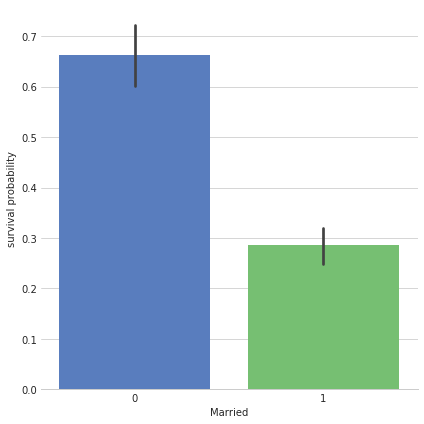

In [28]:
def mapMaritalStatus(title):
    dMaritalStatus = {'Mr': 'Married',
              'Mrs': 'Married',
              'Miss':'Unmarried',
              'Ms':'Unmarried',
              'Sir': 'Married',
              'Mme':'Married',
              'Lady': 'Married',
              'Mlle':'Unmarried',
              'Col': 'Married',
              'Capt':'Married',
              'Don': 'Married',
              'the Countess': 'Married',
              'Jonkheer': 'Married',
              'Major':'Married',
              'Master':'Unmarried',
              'Rev': 'Unmarried',
              'Dr': 'Married'
             }
    
    try:
        if dMaritalStatus[title] == 'Married':
            return 1
        else:
            return 0
    except KeyError:
        return 0


df_dataset['Married'] =  all_titles.apply(lambda x: mapMaritalStatus(x))


g = sns.factorplot(x="Married",y="Survived",data=df_dataset[:train_len],kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [29]:
df_dataset  = df_dataset.drop(['Name'], axis = 1)

# 4.2 Extracting features from cabin

From cabin we can extract the probable location of the passanger (the lower the deck, the harder to get to the surface), and catch patterns like on which side of the boat it was best to be at. We can also see if you shared the cabin with many people.

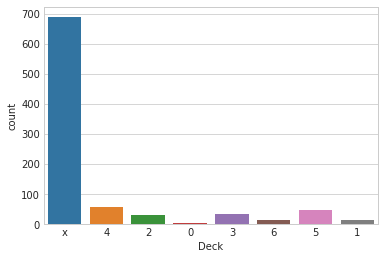

In [30]:
def findDeck(cabin):
    #map up deck to floors
    deckToFloor = {'G':0, 'F': 1, 'E': 2, 'D': 3 , 'C': 4, 'B': 5, 'A': 6}
    try:
        return int(deckToFloor[re.search('[a-zA-Z]+', cabin).group(0)])
    except: 
        return 'x'
    
def findCabinNumber(cabin):
    try:
        return int(re.search('[0-9]+', cabin).group(0))
    except: 
        return 'x'

  

df_dataset['Deck'] = df_dataset['Cabin'].apply(lambda x: findDeck(x))
df_dataset['Cabin_no'] = df_dataset['Cabin'].apply(lambda x: findCabinNumber(x))


#I'll save the cabin unknown feature in a new column.
df_dataset['Cabin_unknown'] = df_dataset['Cabin_no'].apply(lambda row: 1 if row == 'x' else 0)


#for some reason, the values does not become numerics. I'll make them numeric
df_dataset.loc[df_dataset['Cabin_no'] != 'x', 'Cabin_no'] = df_dataset.loc[df_dataset['Cabin_no'] != 'x', 'Cabin_no'].apply(pd.to_numeric, args = ('coerse',))
df_dataset.loc[df_dataset['Deck'] != 'x', 'Deck'] = df_dataset.loc[df_dataset['Deck'] != 'x', 'Deck'].apply(pd.to_numeric, args = ('coerse',))

sns.countplot(x="Deck", data=df_dataset[:train_len]) 
plt.show()


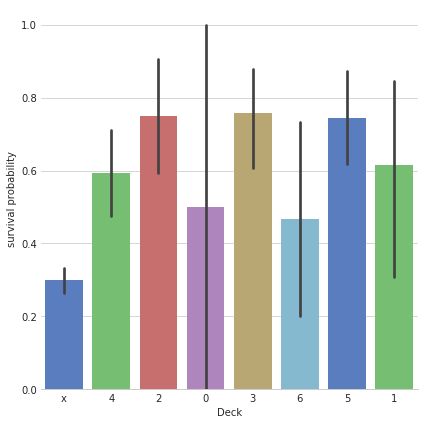

In [31]:
g = sns.factorplot(x="Deck",y="Survived",data=df_dataset[:train_len],kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

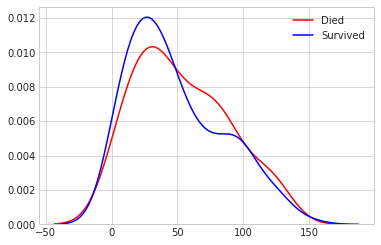

In [32]:
df_train = df_dataset[:train_len]

cabin_data = df_train.loc[df_train['Cabin_no'] != 'x']

sns.kdeplot(cabin_data.loc[cabin_data['Survived'] == 0]['Cabin_no'] , color="red", label="Died")
sns.kdeplot(cabin_data.loc[cabin_data['Survived'] == 1]['Cabin_no'] , color="blue", label="Survived")

Cabin and floor unknown feature - that we do not know the cabin or the floor of a specific person can also say something.

Since I've saved the cabin unknown feature, I'll see if I can impute it in some way. Is there any pattern to the cabins according to your class?. What characterize passanger where we do not know the cabin no?

In [33]:
corr_data = df_train.drop(df_train.loc[df_train['Cabin_no'] == 'x'].index)
#need to force the cabin no to numerics
corr_data['Cabin_no'] = corr_data['Cabin_no'].apply(pd.to_numeric, args = ('coerse',))
corr_matrix = corr_data.corr()
corr_matrix['Cabin_no'].sort_values(ascending = False)

Cabin_no         1.000000
Embarked_Q       0.094115
Married          0.075206
Age              0.066266
Commoner         0.065674
Sex_male         0.053187
PassengerId      0.035941
Embarked_C       0.011753
Fare            -0.006693
Military        -0.012098
Embarked_S      -0.025660
Pclass          -0.036776
Sex_female      -0.053187
Survived        -0.063747
SibSp           -0.064264
Nobility        -0.067424
Parch           -0.117619
Cabin_unknown         NaN
Name: Cabin_no, dtype: float64

Seems like we have the most significant correlations for parch and embarking at Q. I do not see why parch should matter though. I'll look at embarked and see if the distributions seem alike.

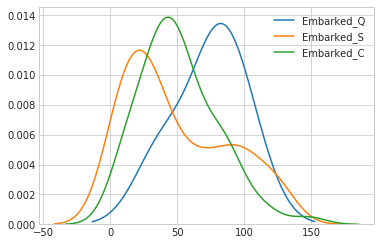

In [34]:
sns.kdeplot(df_train.loc[(df_train['Cabin_no'] != 'x' ) & (df_train['Embarked_Q'] == 1 ), 'Cabin_no'], label = 'Embarked_Q')
sns.kdeplot(df_train.loc[(df_train['Cabin_no'] != 'x' ) & (df_train['Embarked_S'] == 1 ), 'Cabin_no'], label = 'Embarked_S')
sns.kdeplot(df_train.loc[(df_train['Cabin_no'] != 'x' ) & (df_train['Embarked_C'] == 1 ), 'Cabin_no'], label = 'Embarked_C')

The distributions differ - the mean cabin differ. I'll use this to impute the cabin number, as it seems the ship was filled up somewhat according to where you embarked.

In [35]:
mean_Q = df_train.loc[(df_train['Cabin_no'] != 'x' ) & (df_train['Embarked_Q'] == 1 ), 'Cabin_no'].mean()
mean_S  = df_train.loc[(df_train['Cabin_no'] != 'x' ) & (df_train['Embarked_S'] == 1 ), 'Cabin_no'].mean()
mean_C = df_train.loc[(df_train['Cabin_no'] != 'x' ) & (df_train['Embarked_C'] == 1 ), 'Cabin_no'].mean()

df_dataset.loc[(df_dataset['Cabin_no'] == 'x' ) & (df_dataset['Embarked_Q'] == 1 ), 'Cabin_no'] = int(mean_Q)
df_dataset.loc[(df_dataset['Cabin_no'] == 'x' ) & (df_dataset['Embarked_S'] == 1 ), 'Cabin_no']= int(mean_S)
df_dataset.loc[(df_dataset['Cabin_no'] == 'x' ) & (df_dataset['Embarked_C'] == 1 ), 'Cabin_no']= int(mean_C)

In [36]:
print(int(mean_Q))
print(int(mean_S))
print(int(mean_C))

73
49
51


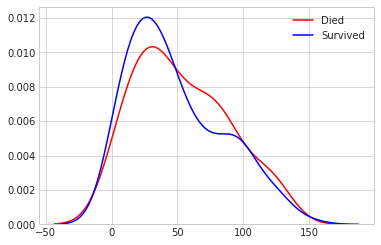

In [37]:
sns.kdeplot(cabin_data.loc[cabin_data['Survived'] == 0]['Cabin_no'] , color="red", label="Died")
sns.kdeplot(cabin_data.loc[cabin_data['Survived'] == 1]['Cabin_no'] , color="blue", label="Survived")

I'll do the same for Deck to impute values

In [38]:
corr_data = df_train.drop(df_train.loc[df_train['Deck'] == 'x'].index)
#need to force the cabin no to numerics
corr_data['Deck'] = corr_data['Deck'].apply(pd.to_numeric, args = ('coerse',))
corr_matrix = corr_data.corr()
corr_matrix['Deck'].sort_values(ascending = False)

Deck             1.000000
Fare             0.323746
Embarked_C       0.256223
Age              0.192717
Military         0.134775
Married          0.101834
Sex_male         0.096953
PassengerId      0.083671
Nobility         0.025182
Parch           -0.033374
Survived        -0.041841
SibSp           -0.047626
Cabin_unknown   -0.053606
Embarked_Q      -0.086658
Commoner        -0.089878
Sex_female      -0.096953
Embarked_S      -0.245905
Pclass          -0.619288
Name: Deck, dtype: float64

Seems like we have the most significant correlations for Pclass. That makes sense I think as the higher the class, the lower the cabin deck. I'll look at Pclass and see if the distributions seem alike.

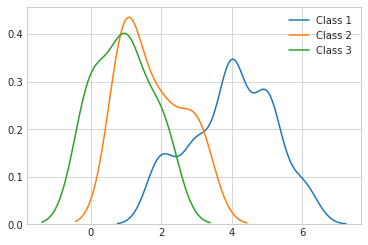

In [39]:
sns.kdeplot(df_train.loc[(df_train['Deck'] != 'x' ) & (df_train['Pclass'] == 1 ), 'Deck'], label = 'Class 1')
sns.kdeplot(df_train.loc[(df_train['Deck'] != 'x' ) & (df_train['Pclass'] == 2 ), 'Deck'], label = 'Class 2')
sns.kdeplot(df_train.loc[(df_train['Deck'] != 'x' ) & (df_train['Pclass'] == 3 ), 'Deck'], label = 'Class 3')

The distributions differ - the mean deck differ. I'll use this to impute the deck, as it seems the ship you got a lower deck the lower your class

In [40]:
mean_1 = df_train.loc[(df_train['Deck'] != 'x' ) & (df_train['Pclass'] == 1 ), 'Deck'].mean()
mean_2  = df_train.loc[(df_train['Deck'] != 'x' ) & (df_train['Pclass'] == 2 ), 'Deck'].mean()
mean_3 = df_train.loc[(df_train['Deck'] != 'x' ) & (df_train['Pclass'] == 3 ), 'Deck'].mean()

df_dataset.loc[(df_dataset['Deck'] == 'x' ) & (df_dataset['Pclass'] == 1 ), 'Deck'] = int(mean_1)
df_dataset.loc[(df_dataset['Deck'] == 'x' ) & (df_dataset['Pclass'] == 2 ), 'Deck']= int(mean_2)
df_dataset.loc[(df_dataset['Deck'] == 'x' ) & (df_dataset['Pclass'] == 3 ), 'Deck']= int(mean_3)

In [41]:
print(int(mean_1))
print(int(mean_2))
print(int(mean_3))

3
1
0


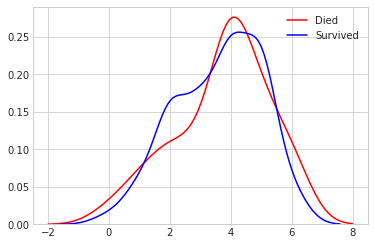

In [42]:
sns.kdeplot(cabin_data.loc[cabin_data['Survived'] == 0]['Deck'] , color="red", label="Died")
sns.kdeplot(cabin_data.loc[cabin_data['Survived'] == 1]['Deck'] , color="blue", label="Survived")

## Sharing cabin with how many 

Can give an indication on how many close friends or family you traveled with. For those with an unknown cabin number, I'll impute it with Pclass. If you've seen the movie, you know that poor people shared with many others while the rich had luxury rooms for their familiy.

In [43]:
sharing_cabin = df_dataset[['PassengerId', 'Cabin']].groupby(['Cabin']).count()
sharing_cabin =  sharing_cabin.rename(columns={'PassengerId':'sharing_cabin_with'})
sharing_cabin = sharing_cabin.reset_index(drop = False)
df_dataset = pd.merge(df_dataset, sharing_cabin[['Cabin', 'sharing_cabin_with']], how = 'left', on = 'Cabin')

#If I use the filled in value here, there is to many people sharing cabins. Well impute this in accordance to Pclass or something similar
df_dataset.loc[df_dataset['Cabin_unknown'] == 1, 'sharing_cabin_with'] = 'x'

Imputing the missing values based on Pclass:

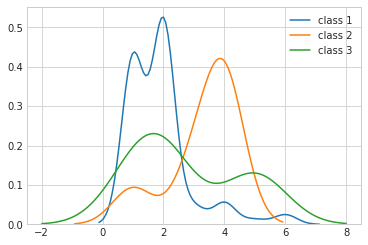

In [44]:
df_train = df_dataset[:train_len]

sns.kdeplot(df_train.loc[(df_train['sharing_cabin_with'] != 'x' ) & (df_train['Pclass'] == 1 ), 'sharing_cabin_with'], label = 'class 1')
sns.kdeplot(df_train.loc[(df_train['sharing_cabin_with'] != 'x' ) & (df_train['Pclass'] == 2 ), 'sharing_cabin_with'], label = 'class 2')
sns.kdeplot(df_train.loc[(df_train['sharing_cabin_with'] != 'x' ) & (df_train['Pclass'] == 3 ), 'sharing_cabin_with'], label = 'class 3')

In [45]:
mean_1 = df_train.loc[(df_train['sharing_cabin_with'] != 'x' ) & (df_train['Pclass'] == 1 ), 'sharing_cabin_with'].mean()
mean_2  = df_train.loc[(df_train['sharing_cabin_with'] != 'x' ) & (df_train['Pclass'] == 2 ), 'sharing_cabin_with'].mean()
mean_3 = df_train.loc[(df_train['sharing_cabin_with'] != 'x' ) & (df_train['Pclass'] == 3 ), 'sharing_cabin_with'].mean()

df_dataset.loc[(df_dataset['sharing_cabin_with'] == 'x' ) & (df_dataset['Pclass'] == 1 ), 'sharing_cabin_with'] = int(mean_1)
df_dataset.loc[(df_dataset['sharing_cabin_with'] == 'x' ) & (df_dataset['Pclass'] == 2 ), 'sharing_cabin_with']= int(mean_2)
df_dataset.loc[(df_dataset['sharing_cabin_with'] == 'x' ) & (df_dataset['Pclass'] == 3 ), 'sharing_cabin_with']= int(mean_3)


df_dataset['sharing_cabin_with'] = df_dataset['sharing_cabin_with'].apply(pd.to_numeric, args = ('coerse',))

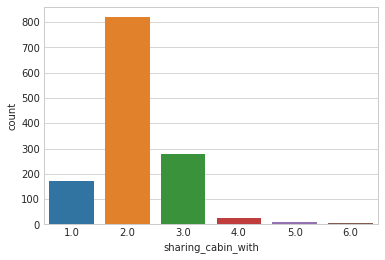

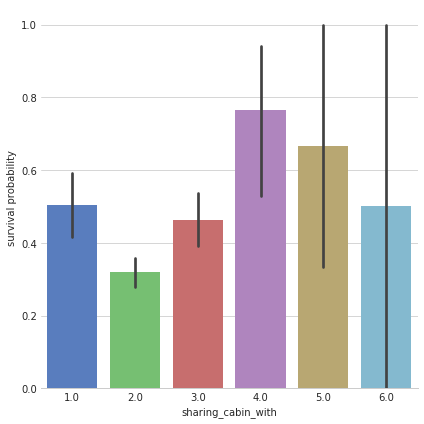

In [46]:
sns.countplot(x="sharing_cabin_with", data=df_dataset) 
plt.show()   


g = sns.factorplot(x="sharing_cabin_with",y="Survived",data=df_dataset.loc[:train_len],kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

I expected a more stair-shaped graph, but it may be that I filled in too many unknown values (at least for 2.0, as that was the median)

In [47]:
df_dataset = df_dataset.drop('Cabin', axis = 1)

## 4.3 Extracting features from Parch and SibSp

From this you can get familysize and probabily other things as well. I was thinking I can use this together with last name and married/unmarried to figure out who had their spouse with them and who had their sibling with them

Parch = parent/children (the number of your parents and/or children onboard)

SibSp = Siblings/Spouses (the number of your siblings and/or spouses onboard)


What are the intervals? What are max and min?

In [48]:
df_train.groupby('Parch')['PassengerId'].nunique()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: PassengerId, dtype: int64

In [49]:
df_train.groupby('SibSp')['PassengerId'].nunique()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: PassengerId, dtype: int64

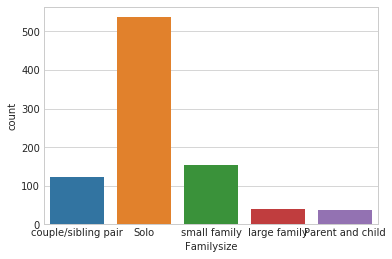

In [50]:
def getFamilySize(parCh, sibSp):
    
    #solo traveling
    if parCh ==  0 and sibSp == 0:
        return 'Solo'
    #can eiter be a married couple or two siblings
    if parCh == 0 and sibSp == 1:
        return 'couple/sibling pair'    
    if parCh == 1 and sibSp == 0:
        return 'Parent and child'
    if parCh > 3 or sibSp > 3:
        return 'large family'
    else:
        return 'small family'
    
    


df_dataset['Familysize'] = df_dataset.apply(lambda row: getFamilySize(row['Parch'], row['SibSp']), axis = 1)

sns.countplot(x='Familysize', data=df_dataset[:train_len])

In [51]:
df_train =df_dataset[:train_len]
corr = []
for i in np.unique(df_train['Familysize']):
    corr_data = df_train[['Familysize', 'Age', 'Survived']].dropna(how = 'any')
    age = corr_data.loc[corr_data['Familysize'] == i]['Age']
    survived = corr_data.loc[corr_data['Familysize'] == i]['Survived']
    print("Age vs survival: Pearsons and p for  {}:  {} ".format(pearsonr(age, survived), i))

Age vs survival: Pearsons and p for  (-0.2724998180422203, 0.10274120040566453):  Parent and child 
Age vs survival: Pearsons and p for  (-0.02185325032194871, 0.6614325257550777):  Solo 
Age vs survival: Pearsons and p for  (0.08308541528480855, 0.4064163717783682):  couple/sibling pair 
Age vs survival: Pearsons and p for  (-0.05037444196374678, 0.7807069650115348):  large family 
Age vs survival: Pearsons and p for  (-0.1730996617867091, 0.042324264483331694):  small family 


In [52]:
df_dataset = pd.get_dummies(df_dataset,columns = ['Familysize'])

Age has different distributions in the difference familysizes, but not good enough to assign ages to people according to the existing distribution inte the subpopulation of the familysizes. SibSp is better even. I'll let it be and just create a large family dummy.

In [53]:
for i in np.unique(df_train['SibSp']):
    corr_data = df_train[['SibSp', 'Age', 'Survived']].dropna(how = 'any')
    age = corr_data.loc[corr_data['SibSp'] == i]['Age']
    survived = corr_data.loc[corr_data['SibSp'] == i]['Survived']
    print("Correlation and p-value of sibSP = {}:  {}".format(i,pearsonr(age, survived)))

Correlation and p-value of sibSP = 0:  (-0.12208746285996529, 0.007989905801481366)
Correlation and p-value of sibSP = 1:  (-0.11341120580592919, 0.12635820100167436)
Correlation and p-value of sibSP = 2:  (-0.26512182800295375, 0.20026054559648704)
Correlation and p-value of sibSP = 3:  (0.8864195589397436, 0.00012266819229976334)
Correlation and p-value of sibSP = 4:  (0.12047830774396714, 0.6339380831997368)
Correlation and p-value of sibSP = 5:  (nan, 1.0)
Correlation and p-value of sibSP = 8:  (nan, nan)


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


## 4.3 Extracting features from ticket

#TODO

## 4.4 Age

A lot of people does not have age. I'll try to impute it and later on compare the performance with imputed values of just not adding any age feature. 


### Imputing missing age

In [54]:
df_train = df_dataset[:train_len]
#what is age correlated to?
corr_data = df_train.drop(df_train.loc[df_train['Age'].isnull()].index).drop(columns = ['Ticket', 'PassengerId', 'Survived'])
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(corr_data)
corr_data_normalized = pd.DataFrame(data = np_scaled, columns = corr_data.columns)

corr_matrix = corr_data_normalized.corr()
corr_matrix['Age'].sort_values(ascending = False)

Age                               1.000000
Married                           0.434581
Deck                              0.335902
Familysize_Solo                   0.198270
Commoner                          0.196317
Military                          0.155622
Fare                              0.117585
Sex_male                          0.093254
Familysize_couple/sibling pair    0.066639
Embarked_C                        0.036261
Cabin_no                          0.019993
Familysize_Parent and child      -0.002806
Embarked_Q                       -0.022405
Embarked_S                       -0.032523
Sex_female                       -0.093254
Familysize_large family          -0.176951
Parch                            -0.189119
sharing_cabin_with               -0.192287
Familysize_small family          -0.212264
Cabin_unknown                    -0.246825
Nobility                         -0.254094
SibSp                            -0.308247
Pclass                           -0.369226
Name: Age, 

Seems like we have the most significant correlations married, deck and Pclass. Others are quite significant as well. I'll see how married and Pclass looks

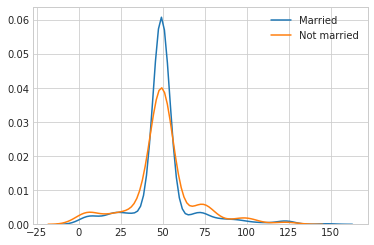

In [55]:
sns.kdeplot(df_train.loc[(df_train['Age'].notnull()) & (df_train['Married'] == 1 ), 'Cabin_no'], label = 'Married')
sns.kdeplot(df_train.loc[(df_train['Age'].notnull()) & (df_train['Married'] == 0 ), 'Cabin_no'], label = 'Not married')

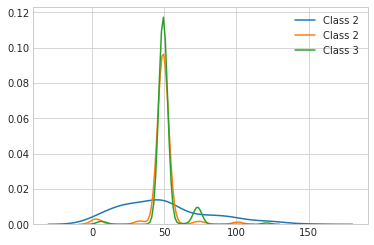

In [56]:
sns.kdeplot(df_train.loc[(df_train['Age'].notnull()) & (df_train['Pclass'] == 1 ), 'Cabin_no'], label = 'Class 2')
sns.kdeplot(df_train.loc[(df_train['Age'].notnull()) & (df_train['Pclass'] == 2 ), 'Cabin_no'], label = 'Class 2')
sns.kdeplot(df_train.loc[(df_train['Age'].notnull()) & (df_train['Pclass'] == 3 ), 'Cabin_no'], label = 'Class 3')

Except for class 2, the mean looks the same when you look at unmarried vs married and Pclasses. I'll try a linear modell to predict the age in order to impute it instead. First I'll create a feature to tell it was missing

In [57]:
df_dataset['Age_unknown'] = 0
df_dataset.loc[df_dataset['Age'].isnull(), 'Age_unknown'] = 1

We'll instead test some simple predictors to impute the age based on the other features. The predictor is only allowed to train on train data, and I'll validate with that as well before deciding which one to chose. I tested some regressior trees of varius depth and a linear regressior. The linear regressior produced the distribution most similar to the target distribution on the test samples, so I'll use that. The trees tended to everfit even for depth = 2

In [58]:
df_train = df_dataset[:train_len].drop(columns = ['Ticket', 'PassengerId', 'Survived'])#train
df_train = df_train.drop(df_train.loc[df_train['Age_unknown'] ==  1].index)

X = df_train.drop(columns = 'Age')
Y = df_train['Age'] #train target

X_predict = df_dataset.loc[df_dataset['Age_unknown'] == 1].drop(columns = ['Ticket', 'PassengerId', 'Survived', 'Age'])#train


#Simple linear regression modell
model1 = LinearRegression()
model1.fit(X,Y)
y_predict = model1.predict(X_predict)



#fill in the missing age
df_dataset.loc[df_dataset['Age_unknown'] == 1, 'Age'] = y_predict


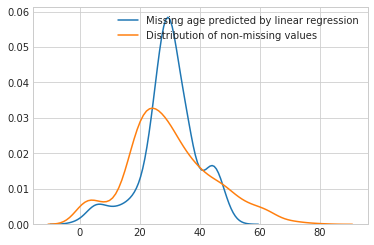

In [59]:
sns.kdeplot(df_dataset.loc[df_dataset['Age_unknown'] == 1, 'Age'], label = 'Missing age predicted by linear regression')
sns.kdeplot(df_dataset.loc[df_dataset['Age_unknown'] ==  0, 'Age'], label = 'Distribution of non-missing values')

Hmmmmmm. I'll leave it as it is now

### Generalizing age

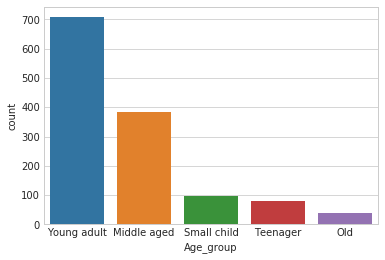

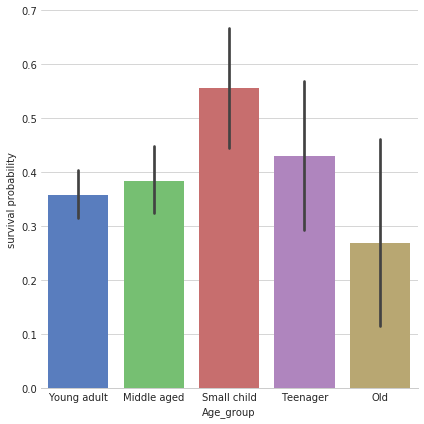

In [60]:
def mapAgeGroup(age):
    if age < 10:
        return 'Small child'
    if age < 18:
        return 'Teenager'
    if age < 35:
        return'Young adult'
    if age < 60:
        return 'Middle aged'
    return 'Old'




df_dataset['Age_group'] = df_dataset.apply(lambda x: mapAgeGroup(x['Age']), axis = 1)

sns.countplot(x="Age_group", data=df_dataset) 
plt.show()   


g = sns.factorplot(x="Age_group",y="Survived",data=df_dataset.loc[:train_len],kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")



df_dataset = pd.get_dummies(df_dataset,columns = ['Age_group'])

# 5 Prepare dataset for modelling

### 5.1 Remove unnecessary data

In [61]:
df_dataset = df_dataset.drop(columns = ['Ticket', 'PassengerId', 'Cabin_no', 'Age'])

## 5.2 Validate data

Even though there shouldn't be any, some inf:s and nan:s may have sneaked into the data. Let's make sure the data is OK to start put into models.

In [62]:
#validation
print(np.any(np.isnan(df_dataset.drop(columns = 'Survived'))))
print(np.all(np.isfinite(df_dataset.drop(columns = 'Survived'))))

False
True


## 5.3 Separeate test and training data

In [63]:
train = df_dataset.loc[:train_len-1]
test = df_dataset.loc[train_len:].drop(columns = 'Survived')



#set up target
Y_train = train['Survived']
X_train = train.drop(columns = 'Survived')


X_test = test

## 5.4 Normalize

Depending on the type of algo, I should scale or standardize. For decision trees which I'll focus on first, I want to keep the data in the same scale, but I do not care about it being Gaussian distributed.

In [64]:
def normData(dataframe):
    min_max=preprocessing.MinMaxScaler()
    np_data = min_max.fit_transform(dataframe)
    return pd.DataFrame(data = np_data, columns = dataframe.columns)
    #normalize to fit into standard support vector machine and not let features with large magnitude and variations dominate
    #return preprocessing.scale(df_dataset)
    
    
#normalize numeric data (not encoded) 
columns_to_norm = ['Fare','Parch','Deck', 'sharing_cabin_with', 'SibSp', 'Pclass']

#cast all columns to norm to floats
for col in columns_to_norm:
    train.loc[:,col] = train[col].astype('float')
    test.loc[:,col] = test[col].astype('float')

#the normed dataframes
norm_train = normData(train[columns_to_norm])
norm_test = normData(test[columns_to_norm])

#fill column per column
for col in norm_train.columns:
    train.loc[:,col] = norm_train[col]
    test.loc[:,col] = norm_test[col]


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# 6 Modelling

## 6.0 Unsupervised clustering

#TODO

## 6.1 Spot testing with cross validation

Just for fun. For the best results, I should adapt the data to the different models, but I'll test this first

/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


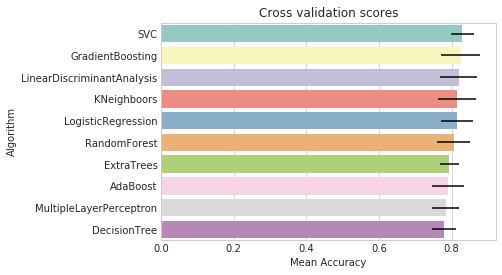

In [65]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)


# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
#for the 4 tries, collect mean accuracy and std. 
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

#store results in dataframe
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

#sort on cv means
cv_res = cv_res.sort_values(by = 'CrossValMeans', ascending = False)

#plot
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [66]:
cv_res['CrossValMeans']

0    0.829409
5    0.825015
9    0.819334
7    0.814965
8    0.814827
3    0.805838
4    0.793592
2    0.790283
6    0.784539
1    0.779084
Name: CrossValMeans, dtype: float64

## 6.2  Predicting using decision tree

I'll start with decision trees since I'm very curious how it will look like, and it will be fun to plot.


### Find best depth with cv

In [67]:
#kfolds
cv = StratifiedKFold(n_splits=10)
train = df_dataset.loc[:train_len-1]


accuracies = list()
max_attributes = len(list(train))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(X = train.drop(['Survived'], axis ='columns'), y = train['Survived']):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
#show results
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]].sort_values(by = 'Average Accuracy', ascending = False)
print(df.to_string(index=False))

Max Depth  Average Accuracy
        5          0.809334
        6          0.809322
        3          0.805863
        4          0.803754
       10          0.800370
       11          0.798098
        7          0.796949
        8          0.795838
       12          0.793615
       13          0.792542
       22          0.792530
        9          0.791406
       25          0.789171
       15          0.789171
       16          0.789158
       24          0.789146
       14          0.789121
       27          0.788048
       26          0.786936
       18          0.786912
       20          0.786899
        1          0.786698
       28          0.785775
       23          0.784714
       19          0.784689
       17          0.784664
       21          0.781331
        2          0.780069


We'll use depth = 5 to continue! 

## Plot tree

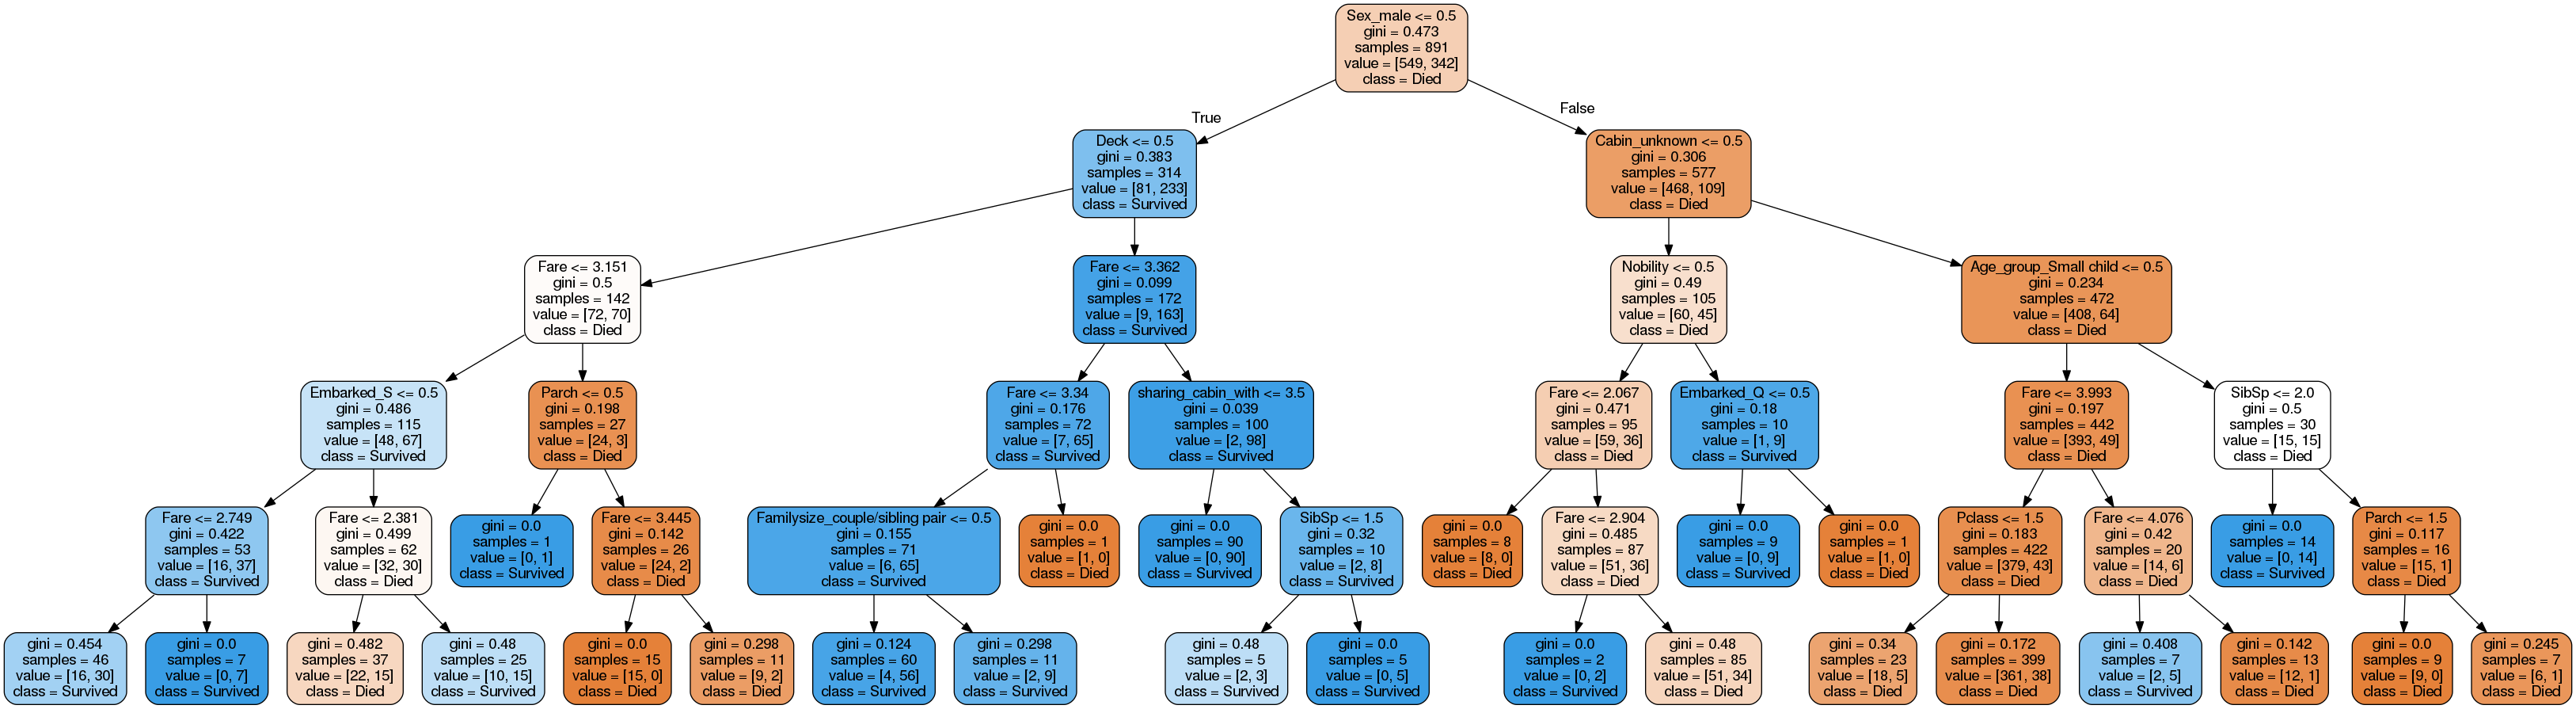

In [73]:
#set up test, train and target as np arrays
Y_train = train['Survived']
X_train = train.drop(columns = 'Survived')
X_test = test

# Create Decision Tree with max_depth = 3
model = DecisionTreeClassifier(max_depth = 5)
model.fit(X_train, Y_train)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = export_graphviz(model,
                              out_file=f,
                              max_depth = 5,
                              impurity = True,
                              feature_names = list(train.drop(['Survived'], axis=1)),
                              class_names = ['Died', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
PImage("sample-out.png")



## 6.3 Roc curves

In [ ]:
#TODO

## 6.4 Feature importance

In [ ]:
# TODO